In [3]:
!pip install torch torchvision matplotlib pandas

   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.5/241.3 MB 1.9 MB/s eta 0:02:10
   ---------------------------------------- 1.0/241.3 MB 2.2 MB/s eta 0:01:50
   ---------------------------------------- 1.6/241.3 MB 2.5 MB/s eta 0:01:38
   ---------------------------------------- 2.1/241.3 MB 2.4 MB/s eta 0:01:40
   ---------------------------------------- 2.4/241.3 MB 2.0 MB/s eta 0:01:58
   ---------------------------------------- 2.6/241.3 MB 2.0 MB/s eta 0:02:02
   ---------------------------------------- 2.9/241.3 MB 1.9 MB/s eta 0:02:07
    --------------------------------------- 3.4/241.3 MB 2.0 MB/s eta 0:02:00
    --------------------------------------- 3.9/241.3 MB 2.0 MB/s eta 0:02:00
    --------------------------------------- 4.2/241.3 MB 1.9 MB/s eta 0:02:09
    --------------------------------------- 4.5/241.3 MB 1.8 MB/s eta 0:02:09


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [5]:
class ICImageDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []

        # Real images = 1
        for img_name in os.listdir(real_dir):
            if img_name.lower().endswith(('.jpg','.png','.jpeg')):
                self.images.append(os.path.join(real_dir, img_name))
                self.labels.append(1)

        # Fake images = 0
        for img_name in os.listdir(fake_dir):
            if img_name.lower().endswith(('.jpg','.png','.jpeg')):
                self.images.append(os.path.join(fake_dir, img_name))
                self.labels.append(0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)


In [8]:
img_size = (224,224)
batch_size = 32

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

dataset = ICImageDataset(
    real_dir="Dataset/train/real/img",
    fake_dir="Dataset/train/fake/img",
    transform=transform
)

# 80-20 Train/Validation Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Total images: {len(dataset)} | Train: {train_size} | Val: {val_size}")


Total images: 291 | Train: 232 | Val: 59


In [10]:
model = models.resnet18(weights="IMAGENET1K_V1")  # pretrained
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # binary output
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) >= 0.5
            correct += (preds == labels).sum().item()

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    train_losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} "
          f"Train Loss: {epoch_loss:.4f} "
          f"Val Loss: {val_epoch_loss:.4f} "
          f"Val Acc: {val_acc*100:.2f}%")



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\meetd/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:11<00:00, 3.92MB/s]


Epoch 1/10 Train Loss: 0.5237 Val Loss: 0.6486 Val Acc: 57.63%
Epoch 2/10 Train Loss: 0.2733 Val Loss: 0.5929 Val Acc: 76.27%
Epoch 3/10 Train Loss: 0.1296 Val Loss: 0.1172 Val Acc: 96.61%
Epoch 4/10 Train Loss: 0.0917 Val Loss: 0.1132 Val Acc: 96.61%
Epoch 5/10 Train Loss: 0.0646 Val Loss: 0.0639 Val Acc: 98.31%
Epoch 6/10 Train Loss: 0.0487 Val Loss: 0.0466 Val Acc: 100.00%
Epoch 7/10 Train Loss: 0.0808 Val Loss: 0.0155 Val Acc: 100.00%
Epoch 8/10 Train Loss: 0.0752 Val Loss: 0.1536 Val Acc: 93.22%
Epoch 9/10 Train Loss: 0.0489 Val Loss: 0.0500 Val Acc: 98.31%
Epoch 10/10 Train Loss: 0.0251 Val Loss: 0.0532 Val Acc: 98.31%


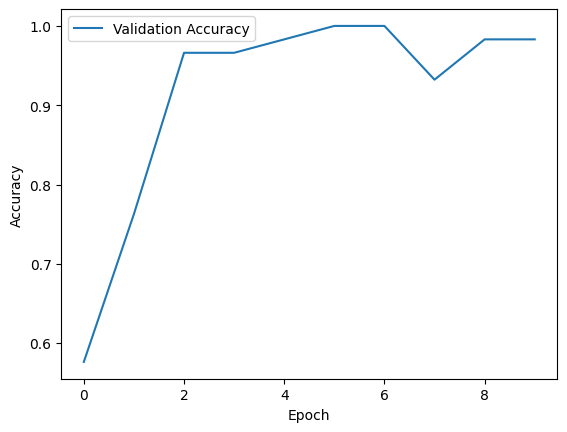

In [11]:
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [12]:
torch.save(model.state_dict(), "ic_real_fake_resnet18.pth")
print("Model saved as ic_real_fake_resnet18.pth")


Model saved as ic_real_fake_resnet18.pth


In [17]:
def predict_image(img_path, model, device):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        prob = torch.sigmoid(output).item()
    if prob >= 0.5:
        return f"Real ({prob*100:.2f}%)"
    else:
        return f"Fake ({(1-prob)*100:.2f}%)"

# Example
print(predict_image("Dataset/Test/images/perfect_leg_3_mp4-56_jpg.rf.a1c21a91835ffbfa8882556f619e3783.jpg", model, device))


Real (99.82%)
